In [ ]:
!pip install open3d

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import numpy as np
import open3d as o3d

# Load the PLY file
def load_ply(filename):
    pcd = o3d.io.read_point_cloud(filename)
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    return points, colors

root = 'gdrive/My Drive/Proyecto/stereo_servoing/output/'

# Load your point clouds
points_3D, colors_cloud = load_ply(root+"point_cloud.ply")
points_3D_new, colors_cloud_new = load_ply(root+"point_cloud_new.ply")

ModuleNotFoundError: ignored

In [ ]:
colors_cloud.shape

(2073600, 3)

In [ ]:
points_3D.shape

(2073600, 3)

In [ ]:
def remove_background(points, depth_threshold):
    """
    Remove background from a point cloud based on a depth threshold.
    points: Nx3 array of the point cloud coordinates.
    depth_threshold: depth value to distinguish foreground from background.
    """
    return points[points[:, 2] < depth_threshold]

# Set a depth threshold (you might need to adjust this based on your scene)
depth_threshold = 100.0  # for example, remove points farther than 3 meters

# Remove background from the point clouds
points_3D_filtered = remove_background(points_3D, depth_threshold)
points_3D_new_filtered = remove_background(points_3D_new, depth_threshold)

# Now, you can apply ICP on the filtered point clouds
# ... (rest of the ICP code)


In [ ]:
points_3D_filtered.shape

(848919, 3)

In [ ]:
import numpy as np
from scipy.spatial import KDTree

def best_fit_transform(A, B):
    """
    Calculate the least-squares best-fit transform between corresponding 3D points A and B.
    """
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Center the points
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    # Compute the rotation matrix using singular value decomposition
    H = A_centered.T @ B_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Ensure a proper rotation matrix
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute the translation vector
    t = centroid_B - (R @ centroid_A)

    return R, t

def apply_icp(A, B, max_iterations=20, tolerance=1e-6):
    """
    The ICP algorithm to compute the transformation matrix.
    """
    prev_error = float('inf')
    for i in range(max_iterations):
        # Find the nearest neighbors from B for each point in A
        kdtree = KDTree(B)
        distances, indices = kdtree.query(A)

        # Estimate the transformation
        R, t = best_fit_transform(A, B[indices])

        # Apply transformation to A
        A = (R @ A.T).T + t

        # Check for convergence
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return R, t

# Randomly select a subset of points from both point clouds
np.random.seed(42)
num_rand_points = 250000
indices = np.random.choice(points_3D_filtered.shape[0], num_rand_points, replace=False)
points_3D_subset = points_3D_filtered[indices]
points_3D_new_subset = points_3D_new_filtered[np.random.choice(points_3D_new_filtered.shape[0], num_rand_points, replace=False)]

# Compute the relative transformation using ICP
R, t = apply_icp(points_3D_new_subset, points_3D_subset)

print("Rotation Matrix (R):")
print(R)
print("\nTranslation Vector (t):")
print(t)


Rotation Matrix (R):
[[ 0.99997166 -0.0051167   0.00552307]
 [ 0.00508159  0.99996691  0.00635283]
 [-0.00555539 -0.00632458  0.99996457]]

Translation Vector (t):
[-0.69715248 -0.69313152  0.09459478]


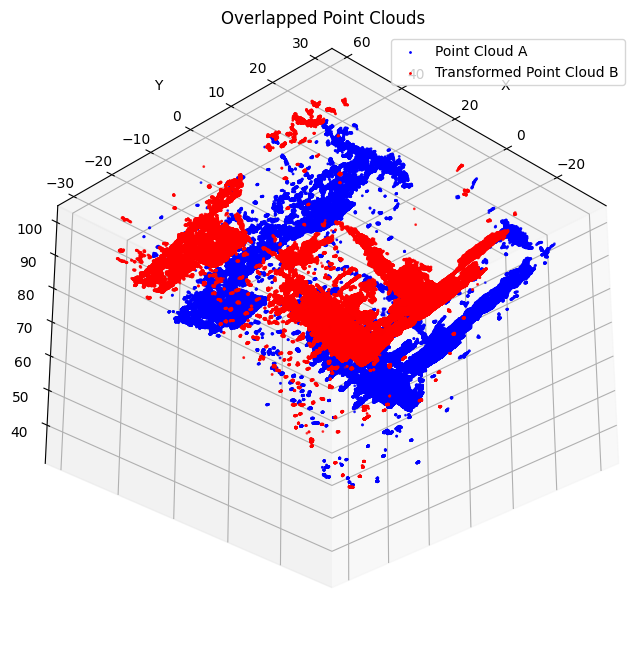

In [ ]:
import matplotlib.pyplot as plt

def visualize_point_clouds(points_A, points_B, R, t, colors_A='blue', colors_B='red'):
    """
    Visualize two point clouds using matplotlib.
    points_A and points_B: Nx3 arrays of the point cloud coordinates.
    R and t: rotation matrix and translation vector from ICP.
    colors_A and colors_B: colors for each point cloud.
    """
    # Transform the second point cloud using R and t
    points_B_transformed = (R @ points_B.T).T + t.T

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the point clouds
    ax.scatter(points_A[:, 0], points_A[:, 1], points_A[:, 2], c=colors_A, s=1, label="Point Cloud A")
    ax.scatter(points_B_transformed[:, 0], points_B_transformed[:, 1], points_B_transformed[:, 2], c=colors_B, s=1, label="Transformed Point Cloud B")

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Overlapped Point Clouds')
    ax.legend()
    ax.view_init(elev=-30, azim=45, roll=0)

    # Show the plot
    plt.show()

# Call the function to visualize the point clouds
visualize_point_clouds(points_3D_subset, points_3D_new_subset, R, t)
